In [1]:
import datetime, os, sys
import yaml
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import HTML
import itertools

notebook_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir))

if project_root not in sys.path:
    sys.path.append(project_root)

with open('../config/params_tcm2024.yaml', 'r') as f:
    config_params = yaml.safe_load(f)

RUNNER_ID = config_params['scraping']['runner_id']
PERSONAL = config_params['personal']
SPLITS_DISTANCE = config_params['splits']['distance']
SPLIT_INFO = config_params['cleaning']['split_info']
SPLITS_CHIPSTART = config_params['splits']['start']['ChipStart']

# Some helper functions

# Convert time values in seconds to a readable format.
readable_time = lambda seconds: np.nan if pd.isna(seconds) else str(datetime.timedelta(seconds=int(seconds)))

# The inverse operation. Convert time from a string in the 'hh:mm:ss' to total seconds.
def time_to_seconds(time_str):
    time = datetime.datetime.strptime(time_str,"%H:%M:%S")
    return datetime.timedelta(hours=time.hour, minutes=time.minute, seconds=time.second).total_seconds()

# Put the time values (in seconds) of the x-axis labels of a coordinate system ax to a readable format.
def format_xticks_labels(ax, xlabel='Final time'):
    x_tick_locs = ax.get_xticks()
    x_tick_labels = [readable_time(tick) for tick in x_tick_locs]    
    ax.set_xticks(x_tick_locs)
    ax.set_xticklabels(x_tick_labels, rotation=60)
    ax.set_xlabel(xlabel)

# Put the time values (in seconds) of the y-axis labels of a coordinate system ax to a readable format.
def format_yticks_labels(ax, ylabel='Final time'):
    y_tick_locs = ax.get_yticks()
    y_tick_labels = [readable_time(tick) for tick in y_tick_locs]    
    ax.set_yticks(y_tick_locs)
    ax.set_yticklabels(y_tick_labels)
    ax.set_ylabel(ylabel)

# Format an output of a pd.Series.describe() to a time-readable format.
def format_describe(data_series, 
                    time_labels = ['mean', 'min', 'max', '25%', '50%', '75%'],
                    numeric_labels = ['std', 'count']):    
    
    stats = data_series.describe()
    stats_formatted = {label: readable_time(stats[label]) for label in time_labels}
    
    numeric_stats = dict(stats[numeric_labels])
    numeric_stats['std'] //= 60 # Convert the standard deviation to minutes.
    numeric_stats['count'] = int(numeric_stats['count'])
    
    stats_formatted.update(numeric_stats)

    return pd.Series(stats_formatted)

# Put a descriptive statistics legend onto a plot with the coordinate system ax.
# The values are converted to a readable format.
def add_stats_legend(data_series, ax, caption='', y_shift=0):    
    stats = format_describe(data_series)

    legend_text = (f'{caption}\n'
                   f'Count: {stats["count"]}\n' # Mind the double quotes.
                   f'Mean: {stats["mean"]}\n'                   
                   f'Min: {stats["min"]}\n'
                   f'Median: {stats["50%"]}\n'
                   f'Max: {stats["max"]}')

    ax.text(0.98, 0.95 - y_shift, legend_text,
            transform=ax.transAxes,
            fontsize=9,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8, ec='gray'))
    ax.set_ylabel('Count')
    

### 1. The initial analysis

In [2]:
output_file_clean = os.path.join(project_root, config_params['cleaning']['output_file'])
df = pd.read_csv(output_file_clean, index_col=RUNNER_ID)
df.head()

,age,sex,residence,split_1_segment_time,split_1_overall_place,split_1_pace,split_2_segment_time,split_2_overall_place,split_2_pace,split_3_segment_time,...,split_8_segment_time,split_8_overall_place,split_8_pace,split_9_segment_time,split_9_overall_place,split_9_pace,split_10_segment_time,split_10_overall_place,split_10_pace,chipstart
runner_id,,,,,,,,,,,,,,,,,,,,,
1001,58.0,F,TX,1834.0,4088.0,591.0,1804.0,4026.0,581.0,1868.0,...,2152.0,4177.0,693.0,2202.0,4076.0,709.0,841.0,3894.0,625.0,322
1013,37.0,M,ID,1436.0,776.0,463.0,1406.0,708.0,453.0,1439.0,...,1969.0,4013.0,634.0,2008.0,3042.0,647.0,905.0,4764.0,673.0,29
1029,36.0,F,MI,1520.0,1362.0,490.0,1492.0,1259.0,480.0,1519.0,...,1661.0,1585.0,535.0,1640.0,1181.0,528.0,656.0,1242.0,487.0,76
1030,25.0,F,MN,1674.0,2515.0,539.0,1681.0,2893.0,541.0,1718.0,...,2090.0,4163.0,673.0,2046.0,3939.0,659.0,824.0,2932.0,613.0,304
1038,49.0,M,MN,2162.0,6245.0,696.0,1952.0,5274.0,629.0,2010.0,...,2518.0,5779.0,811.0,2568.0,5569.0,827.0,995.0,3492.0,740.0,700


Runners with missing split times are to be separated from the main cohort. Missing a checkpoint could have happened due to dropping out of the race or for other reasons. We will review these cases later to detect anomalies.

In [3]:
# The column names are customizable. Cf. config/params.yaml .
segment_time_columns = [f'split_{i}_segment_time' for i, split in enumerate(SPLITS_DISTANCE, start=1)]
segment_pace_columns = [f'split_{i}_pace' for i, split in enumerate(SPLITS_DISTANCE, start=1)]

missing_splits = df[segment_time_columns].isna().any(axis=1)
df_missing = df[missing_splits].copy()
df = df[~missing_splits]

print(f'Split time data is missing for {len(df_missing)} runner(s). {len(df)} entries are kept in the dataset.')

Split time data is missing for 141 runner(s). 6479 entries are kept in the dataset.


There are significantly more entries with missing split data comparing to the TCM 2013.

#### 1.1 Final times distribution

We evaluate the most important characteristic for us -- the final time. For a given runner, this is defined as the total time accumulated over all the split segments.

In [4]:
df['final'] = df[segment_time_columns].sum(axis=1)
final_stats_formatted = format_describe(df['final'])
final_stats_formatted

mean     4:19:43
min      2:10:21
max      6:27:24
25%      3:47:41
50%      4:17:34
75%      4:49:32
std         45.0
count       6479
dtype: object

Addding another useful feature for further analysis -- the cumulative time at the half-marathon split.

In [5]:
half_marathon_split = list(SPLITS_DISTANCE.values()).index(21.1) # The distances are given in km. Cf. config/params.yaml
df['half'] = df[segment_time_columns[:half_marathon_split+1]].sum(axis=1)
half_stats_formatted = format_describe(df['half'])
half_stats_formatted

mean     2:03:16
min      1:05:43
max      2:58:47
25%      1:49:39
50%      2:01:54
75%      2:16:21
std         19.0
count       6479
dtype: object

Let us take a closer look at the final times distribution.

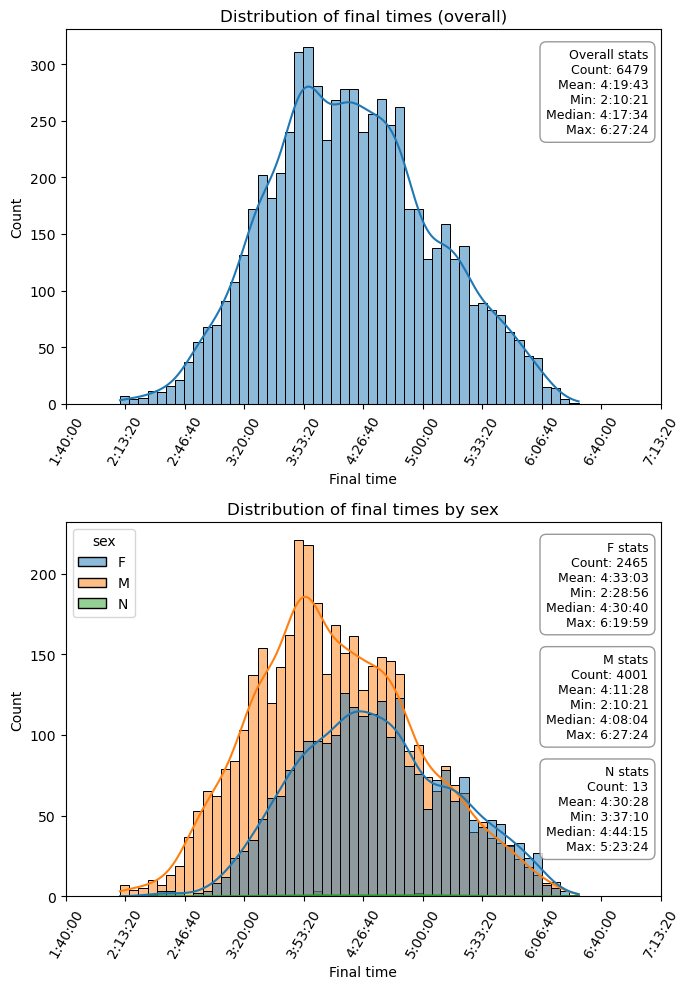

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(7, 10))

# Overall final times distribution.
sns.histplot(df, x='final', 
             bins=50, 
             kde=True, ax=axes[0])
axes[0].set_title('Distribution of final times (overall)')
format_xticks_labels(axes[0])
add_stats_legend(df['final'], axes[0], caption='Overall stats')

# Final times distribution by sex.
sns.histplot(df, x='final', 
             hue='sex', bins=50, 
             kde=True, ax=axes[1])
axes[1].set_title('Distribution of final times by sex')
format_xticks_labels(axes[1])

sex_values = sorted(df['sex'].dropna().unique())
y_delta = 0.3 # An offset is needed between the stats legend boxes, if there is more than one in a plot.

for i, sex in enumerate(sex_values):
    subset_data = df[df['sex'] == sex]['final']
    add_stats_legend(subset_data, axes[1], caption=f'{sex} stats', y_shift=i*y_delta)

plt.tight_layout()
plt.show()

Let us explore the final times distributions by age groups.

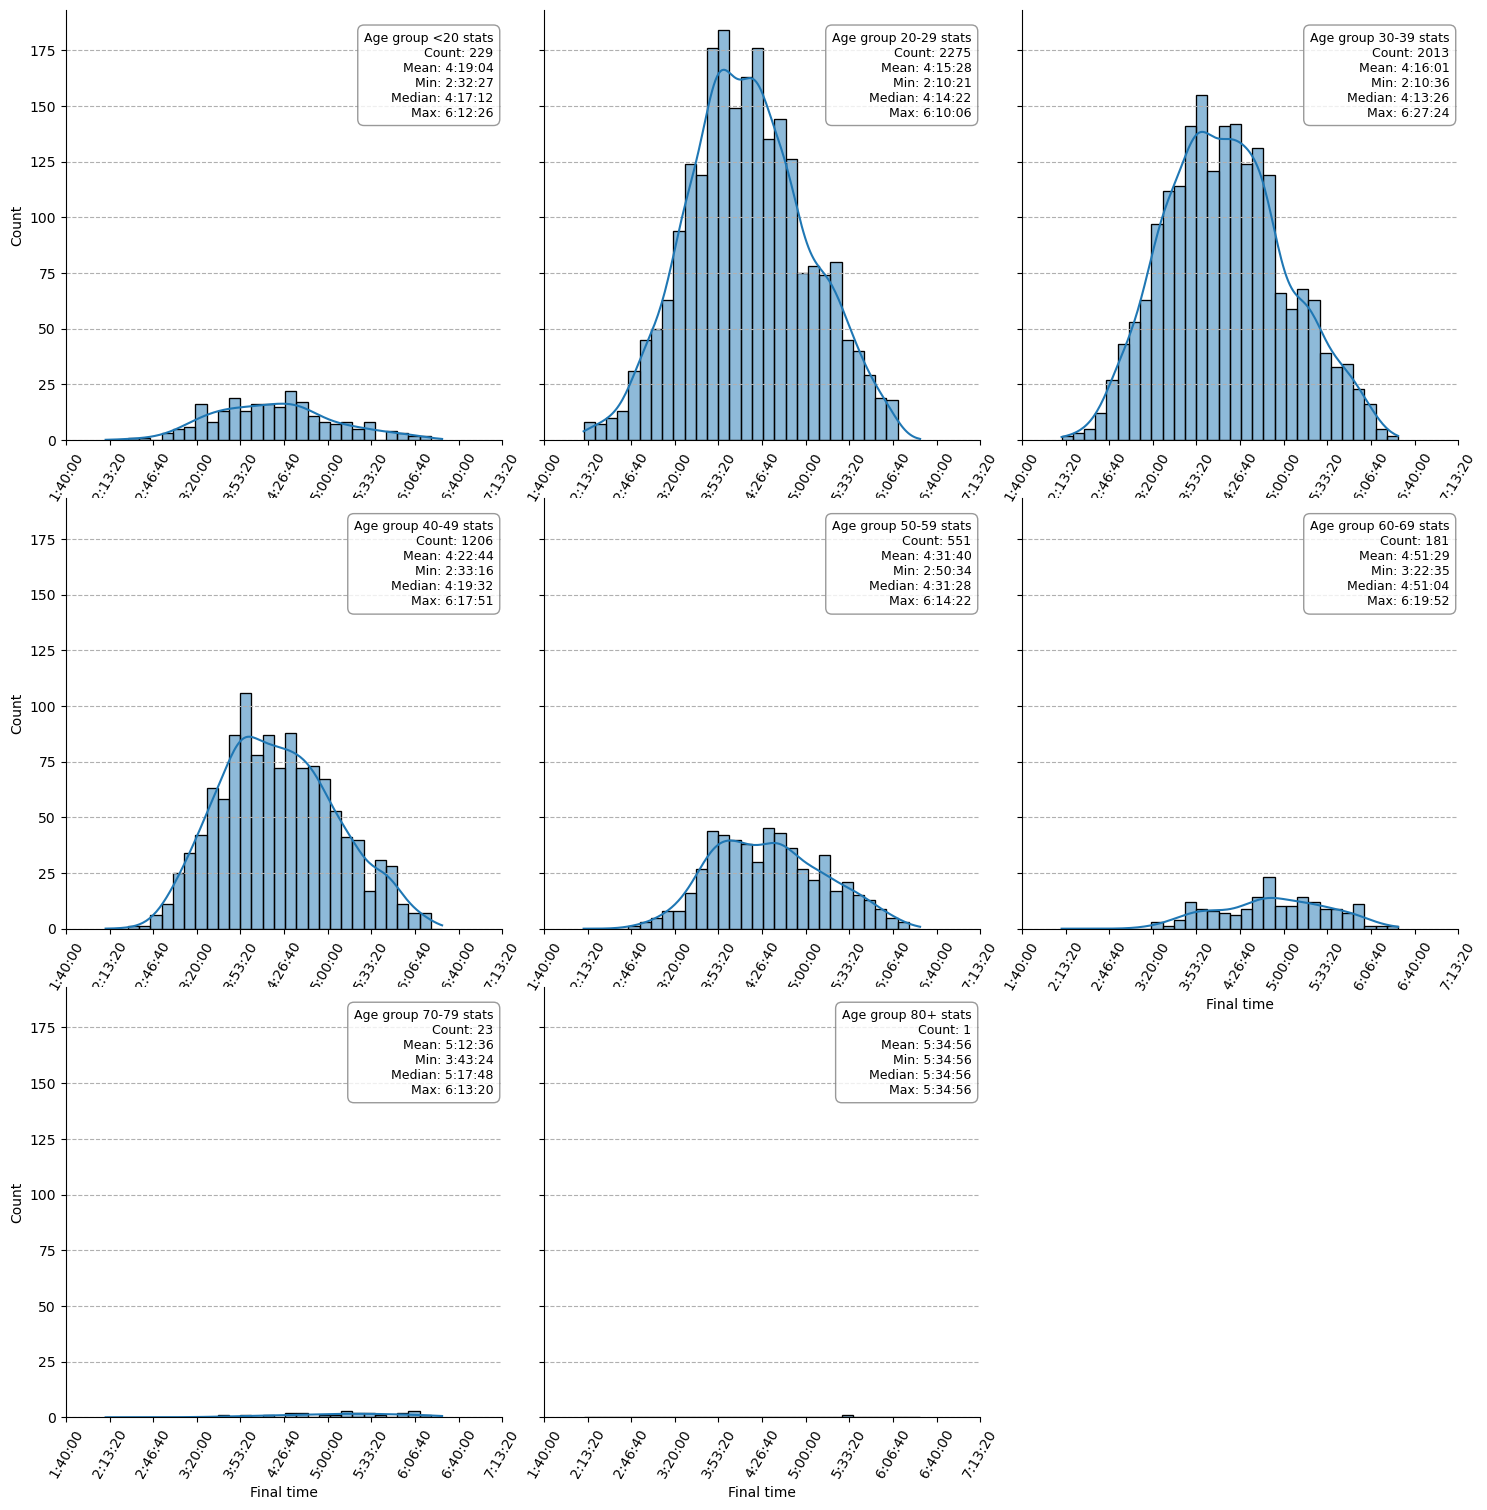

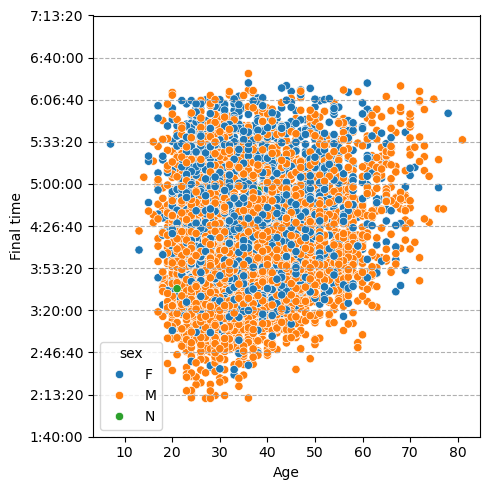

In [7]:
AGE_GROUP_THRESHOLDS = [0, 20, 30, 40, 50, 60, 70, 80, np.inf]
AGE_GROUP_LABELS = ['<20', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']

df = df.reset_index()
df['age_group'] = pd.cut(df['age'], bins=AGE_GROUP_THRESHOLDS, labels=AGE_GROUP_LABELS)

# Overall distribution (by the age group).
g = sns.displot(df, x='final',
                col='age_group', 
                col_wrap=3, bins=30, 
                facet_kws = {'sharex': False},
                kde=True)
g.set_titles(template='')

for i, ax in enumerate(g.axes.flat):
    cur_group = g.col_names[i]
    format_xticks_labels(ax)
    add_stats_legend(df[df['age_group']==cur_group]['final'], 
                     ax, caption=f'Age group {cur_group} stats')
    ax.grid(axis='y', linestyle='--')

# Adding a scatterplot: age/final time.
plt.figure(figsize=(5, 5))

sns.scatterplot(data=df, x='age', y='final', hue='sex')
ax = plt.gca()
format_yticks_labels(ax)
ax.set_xlabel('Age')
plt.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

Let us single out the top 5% of finishers.

In [8]:
top_5_percent = df['final'] <= df['final'].quantile(0.05)

df[top_5_percent].groupby(['age_group', 'sex'], observed=True).size().unstack(fill_value=0)

sex,F,M
age_group,,
<20,1,7
20-29,13,135
30-39,10,117
40-49,1,35
50-59,0,5


In [9]:
final_stats_formatted_top_5_percent = format_describe(df[top_5_percent]['final'])

final_stats_formatted_top_5_percent

mean     2:52:49
min      2:10:21
max      3:08:00
25%      2:47:29
50%      2:56:09
75%      3:02:40
std         12.0
count        324
dtype: object

A bit more info on the runners' demographics.

In [10]:
df['residence'].value_counts().head(), \
df['residence'][top_5_percent].value_counts().head()

(residence
 MN    4652
 WI     351
 IL     176
 IA     141
 CO     115
 Name: count, dtype: int64,
 residence
 MN    188
 WI     25
 IA     12
 CO     12
 IL     10
 Name: count, dtype: int64)

Let us identify the states overrepresented in the top 5% relative to the respective number of participants.

In [11]:
total_by_residence = df['residence'].value_counts()
total_by_residence_in_top_5 = df[top_5_percent]['residence'].value_counts()
relative_representation =(total_by_residence_in_top_5 / len(df[top_5_percent])) / (total_by_residence / len(df))
relative_representation[relative_representation > 1].nlargest(5).round(3)

residence
CH    19.997
EL    19.997
OS     9.998
WV     9.998
ID     6.666
Name: count, dtype: float64

CH, EL, OS stand for the Chiba Prefecture (Japan), Elgeyo-Marakwet County (Kenya) and Osaka Prefecture (Japan) respectively.

#### 1.2 Runners' mass dynamics
Let us take a look at the runners' mass dynamics along the race course. 

Note: the Twin Cities Marathon 2024 had the official cut-off time of 6 hours and 30 minutes.

In [12]:
# A helper function: for each split i, count the number runners, who have passed split i, but haven't gotten to split i+1 yet at the given time.

def count_runners(df_runners, time):
    counts = {}
    # Counting those who have not started yet.
    counts[-1] = len(df_runners[(time < df_runners[f'split_0_cumulative_time'])])
    # Counting runners between the splits.
    for i in range(len(SPLITS_DISTANCE)):
        passed_current = df_runners[f'split_{i}_cumulative_time'] <= time
        before_next = time < df_runners[f'split_{i+1}_cumulative_time']        
        counts[i] = len(df_runners[passed_current & before_next]) 
    # Counting finishers.
    counts[len(SPLITS_DISTANCE)] = len(df_runners[(df_runners['final'] <= time)])
    
    return counts

df['split_0_cumulative_time'] = df[SPLITS_CHIPSTART] # The starting line is an edge case. It is "split zero".
split_labels = ['Start']+ list(SPLITS_DISTANCE.keys())

# Computing the cumulative times registered at the splits along the course.
for i, split in enumerate(SPLITS_DISTANCE, start=1):
    df[f'split_{i}_cumulative_time'] = df[f'split_{i-1}_cumulative_time'] + df[f'split_{i}_segment_time']

fig, ax = plt.subplots()
snapshots = []

# Setting the bar plot looks.
ax.set_ylabel('Count')
ax.set_xticks(range(-1, len(split_labels))) # The starting line is "split zero". The corral (indexed -1) preceeds it.
ax.tick_params(axis='x', rotation=45)
segment_labels = ['Corral'] + [f'{cur}-{nxt}' for cur, nxt in itertools.pairwise(split_labels)] + ['Finished'] 
ax.set_xticklabels(segment_labels, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')

# Taking a runners' distribution snapshot for every 3 minutes over the 6hr30min period.
for time in range(0, int(6.5 * 3600), 3 * 60):    
    counts_overall = count_runners(df, time)
    bars_overall = ax.bar(counts_overall.keys(), counts_overall.values(), 
                          color='skyblue',
                          label='All runners')

    counts_top_5 = count_runners(df[top_5_percent], time)
    bars_top_5 = ax.bar(counts_top_5.keys(), counts_top_5.values(), 
                        color='orange',
                        label='Top 5%')
    
    title = plt.text(0.5, 1.01, readable_time(time), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
    if not ax.get_legend(): # A plot legend is to be added only once, but it has to be introduced after the barplots.
        ax.legend(loc='upper right', title='Runner category')
    
    inter_lines = []    
    # TODO: better interpolation visuals. There seems to an issue with using the standard KDE in sns.histplot for this purpose.
    # Probably, due to all the data fitting into a single bin in the very beginning and the very end of the race.
    line, = ax.plot(counts_overall.keys(), counts_overall.values(), color='blue', linewidth=2, linestyle='-', marker='o', markersize=4)
    inter_lines.append(line)
    
    frame_artists = list(bars_overall) + list(bars_top_5) + inter_lines + [title] # Composing an animation frame.
    snapshots.append(frame_artists)

ani = animation.ArtistAnimation(fig, snapshots, interval=50, blit=False)
plt.tight_layout()
plt.close(fig)

ani_filename =  'runners_passing_2024.mp4'
try:
    print(f'Saving animation to {ani_filename} as MP4...')
    ani.save(ani_filename, writer='ffmpeg', fps=5, dpi=200)
    print(f'Done.')
except Exception as e:
    print(f'Error saving animation: {e}')
    print('Make sure ffmpeg is installed.')

HTML(f'<video width="700" controls autoplay loop><source src="{ani_filename}" type="video/mp4"></video>')

Saving animation to runners_passing_2024.mp4 as MP4...
Done.


#### 1.3 Qualifying for the Boston Marathon
A fairly popular indicator of above-average performance among non-professional runners is meeting the qualifying time standard for the Boston Marathon. A runner aspiring to get a qualification is expected to run a race on a certified course, such as the Twin Cities Marathon, prior to the next upcoming Boston Marathon race. The time standards are set separately for each demographic category.

According to the Boston Athletic Association, in 2020-2025 the qualifying time cut-offs were as follows:

In [13]:
BOSTON_QUALIFYING_STANDARDS = {
    '18-34': {'M': time_to_seconds('3:00:00'), 'F': time_to_seconds('3:30:00')},
    '35-39': {'M': time_to_seconds('3:05:00'), 'F': time_to_seconds('3:35:00')},
    '40-44': {'M': time_to_seconds('3:10:00'), 'F': time_to_seconds('3:40:00')},
    '45-49': {'M': time_to_seconds('3:20:00'), 'F': time_to_seconds('3:50:00')},
    '50-54': {'M': time_to_seconds('3:25:00'), 'F': time_to_seconds('3:55:00')},
    '55-59': {'M': time_to_seconds('3:35:00'), 'F': time_to_seconds('4:05:00')},
    '60-64': {'M': time_to_seconds('3:50:00'), 'F': time_to_seconds('4:20:00')},
    '65-69': {'M': time_to_seconds('4:05:00'), 'F': time_to_seconds('4:35:00')},
    '70-74': {'M': time_to_seconds('4:20:00'), 'F': time_to_seconds('4:50:00')},
    '75-79': {'M': time_to_seconds('4:35:00'), 'F': time_to_seconds('5:05:00')},
    '80+': {'M': time_to_seconds('4:50:00'), 'F': time_to_seconds('5:20:00')}
}
# Note that these age groups are more refined than the age groups we introduced above.

Source: https://www.baa.org/races/boston-marathon/qualify/history-qualifying-times

Some remarks are in order: 
- unlike the Twin Cities Marathon, the Boston Marathon has the minimum age requirement of 18 years of age on the race day, typically taking place in April. We impose this condition onto our dataset as well at the expense of the potential qualifiers in the age bracket of ~17yrs 5months < age < 18 yrs;
- there was no non-binary gender category in the Boston Qualifying standards back in 2024. Since we do not know how this was resolved for the non-binary TCM 2024 participants, who could or could not have met a qualifying standard, we omit such runners for this part of the analysis. 

Let us see the statistics on the runners who have qualified for the Boston Marathon by each age group.

In [14]:
BQ_AGE_THRESHOLDS = [18, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, np.inf]
BQ_AGE_LABELS = ['18-34', '35-39', '40-44', '45-49', '50-54', '55-59',
                 '60-64', '65-69', '70-74', '75-79', '80+']

df['bq_age_group'] = pd.cut(df['age'], bins=BQ_AGE_THRESHOLDS, labels=BQ_AGE_LABELS, right=False)

has_qualified = lambda runner: runner['final'] <= BOSTON_QUALIFYING_STANDARDS[runner['bq_age_group']][runner['sex']]

df['bq_qualified'] = df[df['sex'].isin(['M', 'F'])].dropna(subset=['bq_age_group']).apply(has_qualified, axis=1)
print(df['bq_qualified'].value_counts(dropna=True), 
      df['bq_qualified'].value_counts(dropna=True, normalize=True).mul(100).round(2)) # BQs in percents.

# Note: bq_qualified can be undefined, a NaN.
bq_summary = df[df['bq_qualified'] == True].groupby(['bq_age_group', 'sex'], observed=True).size().unstack(fill_value=0)
bq_proportions = df.groupby(['bq_age_group', 'sex'], observed=True)['bq_qualified'].value_counts(normalize=True, dropna=True).unstack(fill_value=0)

bq_summary, bq_proportions[True].mul(100).round(2)  # BQs in percents by the age groups.

bq_qualified
False    5873
True      563
Name: count, dtype: int64 bq_qualified
False    91.25
True      8.75
Name: proportion, dtype: float64


(sex            F    M
 bq_age_group         
 18-34         87  150
 35-39         44   40
 40-44         41   34
 45-49         28   31
 50-54         11   19
 55-59         16   17
 60-64          9   16
 65-69          9    6
 70-74          0    4
 75-79          1    0,
 bq_age_group  sex
 18-34         F       6.61
               M       7.46
 35-39         F      12.50
               M       6.81
 40-44         F      12.62
               M       6.69
 45-49         F      14.51
               M      10.13
 50-54         F       8.46
               M       9.18
 55-59         F      21.92
               M       9.39
 60-64         F      23.08
               M      16.49
 65-69         F      45.00
               M      11.11
 70-74         F       0.00
               M      14.81
 75-79         F      50.00
               M       0.00
 80+           M       0.00
 Name: True, dtype: float64)

Overall, about 9% of runners had met their respective BQ standards at this race (compared to 11% at the TCM 2013). Women seem to have qualified for the Boston Mararthon at a higher rate than men. The difference is particularly apparent in the senior age groups. 

### 2. Pace dynamics
Let us explore how the average pace over split segments varies during the race for different categories of runners. We will also take a look at two opposite pace dynamics scenarios that emerge in marathon running -- running with a negative split and "hitting the wall".

#### 2.1 Average pace dynamics 

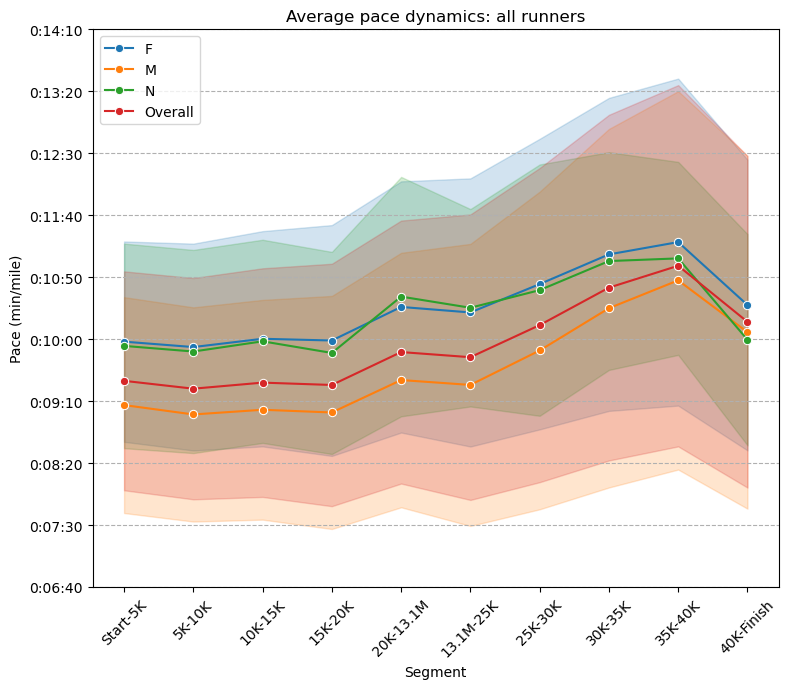

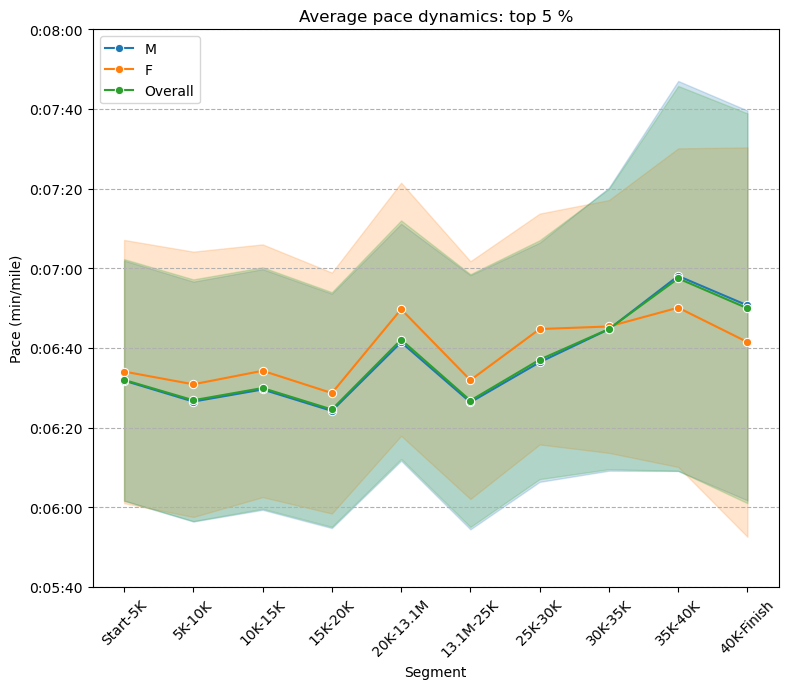

In [15]:
# A helper function.
# Plot aggregated average pace graphs together (hued by a category) on a single chart.

segment_labels =[f'{cur}-{nxt}' for cur, nxt in itertools.pairwise(split_labels)]

def plot_average_pace(df_runners, title):
   
    # An auxiliary dataframe. Introduces a new field 'category' that is either sex or 'Overall' (compound).
    df_pace_calc = df_runners[segment_pace_columns + ['sex']].copy()
    df_pace_calc.rename({'sex':'category'}, inplace=True, axis=1)
    df_pace_calc_copy = df_pace_calc.copy()
    df_pace_calc_copy['category'] = 'Overall'
    df_pace_calc = pd.concat([df_pace_calc, df_pace_calc_copy])

    # Turning split segments dataframe to a long format suitable for the sns.lineplot.
    df_runners_pace = pd.melt(df_pace_calc.reset_index(),
                              id_vars=['category'],
                              value_vars=segment_pace_columns,
                              var_name='split_name',
                              value_name='pace')
    
    plt.figure(figsize=(8, 7))
    
    ax = sns.lineplot(data=df_runners_pace, 
                 x='split_name', y='pace',
                 marker='o', linestyle='-',
                 hue='category',
                 errorbar='sd')
    
    # The looks.
    ax.set_title(f'Average pace dynamics: {title}')
    ax.set_xlabel('Segment')
    ax.set_xticks(range(len(segment_labels)))
    ax.set_xticklabels(segment_labels, rotation=45)
    format_yticks_labels(ax, ylabel='Pace (min/mile)')
    ax.grid(axis='y', linestyle='--')    
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

plot_average_pace(df, 'all runners')
plot_average_pace(df[top_5_percent], 'top 5 %')

Remarkably, women in the top 5% tend to outperform men in the closing stages of the race as far as the running pace is concerned, even though this trend is not observed among the competitive athletes. This was observed in the TCM 2013 data as well.

As another characteristic of the pace dyamics let us consider the average pace gradient defined as the rate of change of the average pace over the distance. That is, it is the second derivative of the cumulative time over distance and indicates acceleration or deceleration of a runner over the race course.

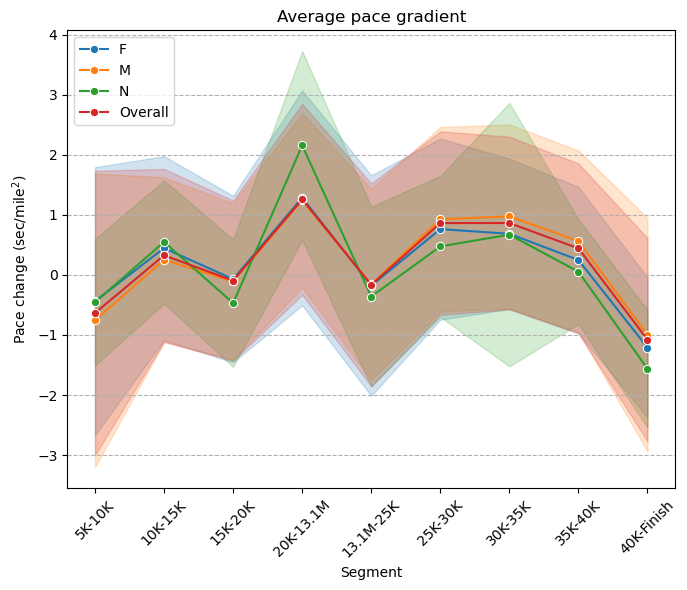

In [16]:
df_pace_calc = df[segment_pace_columns + ['sex']].copy()
df_pace_calc.rename({'sex':'category'}, inplace=True, axis=1)

# An auxiliary dataframe to melt later. Introduces a new field 'category' that is either sex or 'Overall' (compound).
df_pace_gradient = (df_pace_calc[segment_pace_columns].diff(axis=1) / pd.Series(SPLITS_DISTANCE.values(), 
                                                                             index=segment_pace_columns))
df_pace_gradient['category'] = df_pace_calc['category']
df_pace_gradient_copy = df_pace_gradient.copy()
df_pace_gradient_copy['category'] = 'Overall'
df_pace_gradient = pd.concat([df_pace_gradient, df_pace_gradient_copy])

# Turning split segments dataframe to a long format suitable for the sns.lineplot.
df_pace_gradient_long = pd.melt(df_pace_gradient.reset_index(),
                                 id_vars=['category'],
                                 value_vars=segment_pace_columns,
                                 var_name='segment_name',
                                 value_name='pace').dropna() # There will be NaN since backward difference is undefined for split 1.
plt.figure(figsize=(7, 6))
    
ax = sns.lineplot(data=df_pace_gradient_long,
             x='segment_name', y='pace',
             marker='o', linestyle='-',
             hue='category',
             errorbar='sd')

# The looks.
ax.set_title(f'Average pace gradient')
ax.set_xlabel('Segment')
ax.set_xticks(range(len(segment_labels) - 1))
ax.set_xticklabels(segment_labels[1:], rotation=45)
ax.set_ylabel('Pace change (sec/mile$^2$)')
ax.grid(axis='y', linestyle='--')    
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

#### 2.2 Negative splits
Efficient running is often reflected in being able to finish a long-distance race with a negative split, that is, completing the second half of a race faster than the first one. This can be linked to better aerobic efficiency as well as a more skillful or consistent pacing strategy.

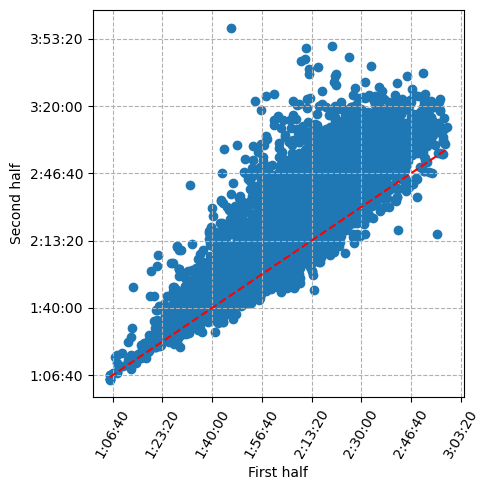

In [17]:
df['second_half'] = df['final'] - df['half']

plt.figure(figsize=(5, 5))
plt.scatter(data=df, x='half', y='second_half')

ax = plt.gca()
format_xticks_labels(ax, 'First half')
format_yticks_labels(ax, 'Second half')
ax.grid(linestyle='--')

line_start, line_end = df['half'].min(), df['half'].max()
diagonal = np.linspace(line_start, line_end, 2)
plt.plot(diagonal, diagonal, linestyle='--', color='red')

plt.tight_layout()
plt.show()

Let us see the statistics on the runners who finished the race with a negative split.

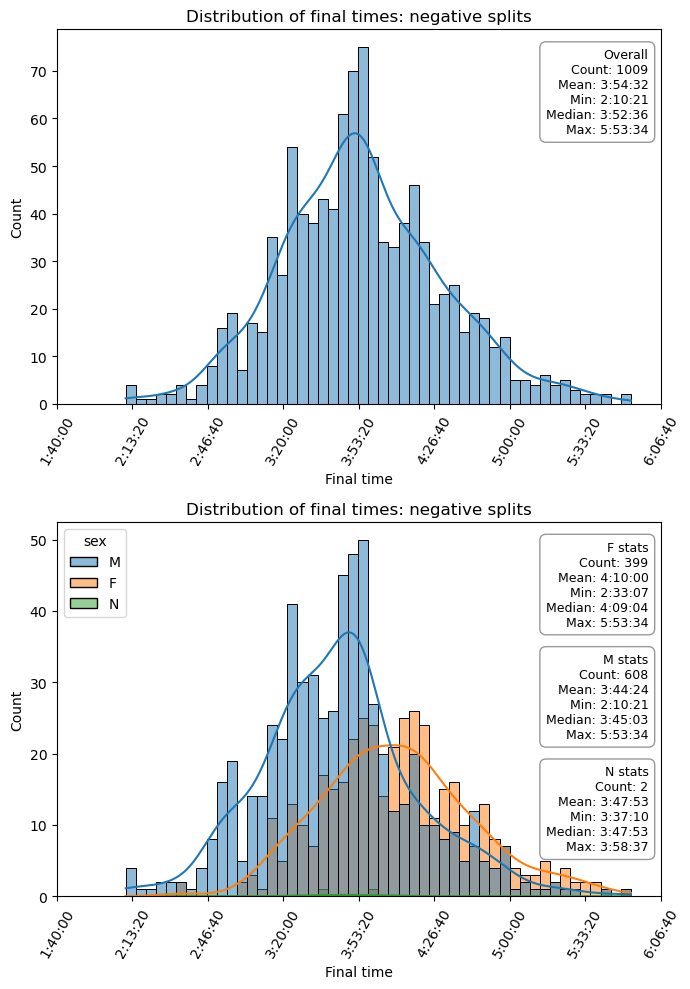

In [18]:
df['abs_half_diff'] = df['second_half'] - df['half']
df['negative_split'] = df['abs_half_diff'] < 0
df['relative_half_diff'] = df['abs_half_diff'] / df['half']
df_negative = df[df['negative_split']]

fig, axes = plt.subplots(2, 1, figsize=(7, 10))

# Negative splits: overall distribution.
sns.histplot(df_negative, x='final', 
             bins=50, 
             kde=True, ax=axes[0])
axes[0].set_title('Distribution of final times: negative splits')
format_xticks_labels(axes[0])
add_stats_legend(df_negative['final'], axes[0], caption='Overall')

# Negative splits: distribution by sex
sns.histplot(df_negative, x='final', 
             hue='sex', bins=50, 
             kde=True, ax=axes[1])
axes[1].set_title('Distribution of final times: negative splits')
format_xticks_labels(axes[1])

sex_values = sorted(df['sex'].dropna().unique())
y_delta = 0.3 # An offset between legend boxes

for i, sex in enumerate(sex_values):
    subset_data = df_negative[df_negative['sex'] == sex]['final']
    add_stats_legend(subset_data, axes[1], 
                     caption=f'{sex} stats', 
                     y_shift=i*y_delta)

plt.tight_layout()
plt.show()

In [19]:
# Reporting on the negative-split runners.
print (df['negative_split'].value_counts(dropna=True), 
       df['negative_split'].value_counts(dropna=True, normalize=True).mul(100).round(2))

negative_summary = df_negative.groupby(['age_group', 'sex'], observed=True).size().unstack(fill_value=0)
negative_proportions = df.groupby(['age_group', 'sex'], observed=True)['negative_split']\
    .value_counts(normalize=True, dropna=True).unstack(fill_value=0)

print(negative_summary)
print(negative_proportions[True].mul(100).round(2))

negative_split
False    5470
True     1009
Name: count, dtype: int64 negative_split
False    84.43
True     15.57
Name: proportion, dtype: float64
sex          F    M  N
age_group             
<20         23   22  0
20-29      193  229  1
30-39      112  200  1
40-49       48   96  0
50-59       22   48  0
60-69        1   12  0
70-79        0    1  0
age_group  sex
<20        F      28.75
           M      14.77
20-29      F      20.73
           M      17.13
           N      14.29
30-39      F      14.95
           M      15.89
           N      20.00
40-49      F      10.21
           M      13.06
           N       0.00
50-59      F      12.02
           M      13.04
60-69      F       2.04
           M       9.09
70-79      F       0.00
           M       5.00
80+        M       0.00
Name: True, dtype: float64


Negative splits can be observed among runners of different athletic abilities, judging by the final time. Comparing to the TCM 2013, more runners were able to finish with a negative split (~9% against ~16%) Negative splits tend to appear more frequently in the younger age groups.

Let us refine the negative splits statistics to the top 5% category.

In [20]:
# Reporting on the negative-split runners in the top 5%.
print(df[top_5_percent]['negative_split'].value_counts(dropna=True), 
      df[top_5_percent]['negative_split'].value_counts(dropna=True, normalize=True).mul(100).round(2))

negative_summary = df[top_5_percent & df['negative_split']].groupby(['age_group', 'sex'], observed=True).size().unstack(fill_value=0)
negative_proportions = df[top_5_percent].groupby(['age_group', 'sex'], observed=True)['negative_split']\
    .value_counts(normalize=True, dropna=True).unstack(fill_value=0)

print(negative_summary)
print(negative_proportions[True].mul(100).round(2))

negative_split
False    239
True      85
Name: count, dtype: int64 negative_split
False    73.77
True     26.23
Name: proportion, dtype: float64
sex        F   M
age_group       
<20        0   3
20-29      4  32
30-39      2  33
40-49      0  10
50-59      0   1
age_group  sex
<20        F       0.00
           M      42.86
20-29      F      30.77
           M      23.70
30-39      F      20.00
           M      28.21
40-49      F       0.00
           M      28.57
50-59      M      20.00
Name: True, dtype: float64


Comparing to the TCM 2013 data, negative splits in the top 5% category also occured more frequently in 2024 (~11% against 26%). It should be noted that the group sizes differ quite significantly in size -- 443 and 324 runners in 2013 and 2024 respectively.

Let us see what the average pace dynamics for the runners with negative splits looks like.

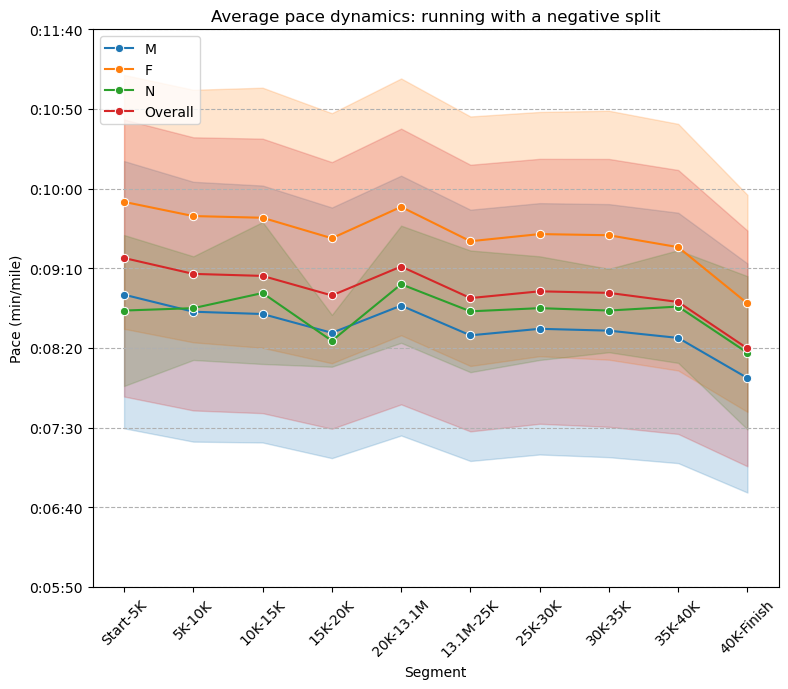

In [21]:
plot_average_pace(df_negative, 'running with a negative split')

Let us identify the outliers -- the runners with the smallest negative relative time difference between the first and the second halves of the race.

In [22]:
top_negative_splits = df['relative_half_diff'].nsmallest(10).index

# Preparing a report table.
negative_splits_table = df[['half', 'second_half', 'final', 'relative_half_diff']].loc[top_negative_splits].copy()
columns_to_format = ['half', 'second_half', 'final']
negative_splits_table[columns_to_format] = negative_splits_table[columns_to_format].apply(lambda row: row.map(readable_time))
negative_splits_table[['relative_half_diff']] = negative_splits_table[['relative_half_diff']].map(lambda x: f'{(100 * x):.2f}%')
negative_splits_table

,half,second_half,final,relative_half_diff
3539,2:55:28,2:16:40,5:12:08,-22.11%
543,2:14:08,1:48:43,4:02:51,-18.95%
1872,2:42:28,2:18:48,5:01:16,-14.57%
6427,2:07:28,1:49:43,3:57:11,-13.93%
1919,2:13:50,1:56:18,4:10:08,-13.10%
602,2:07:40,1:50:58,3:58:38,-13.08%
6326,2:09:30,1:52:36,4:02:06,-13.05%
5511,1:41:09,1:28:15,3:09:24,-12.75%
991,2:03:01,1:47:55,3:50:56,-12.27%
5834,2:04:59,1:49:40,3:54:39,-12.25%


Let us see the negative splitting outliers in the top 5%.

In [23]:
top_negative_splits_comp = df[top_5_percent]['relative_half_diff'].nsmallest(10).index

# Preparing a report table.
negative_splits_table_comp = df[['half', 'second_half', 'final', 'relative_half_diff']].loc[top_negative_splits_comp].copy()
columns_to_format = ['half', 'second_half', 'final']
negative_splits_table_comp[columns_to_format] = negative_splits_table_comp[columns_to_format].apply(lambda row: row.map(readable_time))
negative_splits_table_comp[['relative_half_diff']] = negative_splits_table_comp[['relative_half_diff']].map(lambda x: f'{(100 * x):.2f}%')
negative_splits_table_comp

,half,second_half,final,relative_half_diff
3329,1:29:13,1:20:45,2:49:58,-9.49%
3300,1:36:42,1:28:08,3:04:50,-8.86%
2232,1:36:04,1:29:53,3:05:57,-6.44%
4717,1:35:08,1:29:02,3:04:10,-6.41%
1693,1:27:08,1:22:03,2:49:11,-5.83%
2137,1:28:08,1:23:08,2:51:16,-5.67%
1633,1:32:24,1:27:27,2:59:51,-5.36%
4844,1:34:46,1:30:19,3:05:05,-4.70%
4334,1:28:23,1:24:35,2:52:58,-4.30%
4896,1:31:16,1:27:21,2:58:37,-4.29%


More on the statistics of negative splits: https://fellrnr.com/wiki/Negative_Splits

#### 2.3 Hitting the wall
We turn to the statistics of a phenomenon on the opposite end of a runner's experience spectrum, colloquially called "hitting the wall". It is an abrupt severe drop in the physical output caused by glycogen depletion in the organism, typically happening in the latter stages of the race 
(cf. https://en.wikipedia.org/wiki/Hitting_the_wall and references therein).

As a working definition, let us say that a runner happened to "hit the wall" if the relative difference in time between the first and the second half of the marathon is at least 25%.

In [24]:
hit_the_wall = df['relative_half_diff'] >= 0.25 # The 25% threshold.
df['hit_the_wall'] = hit_the_wall

print (hit_the_wall.value_counts(dropna=True),
       hit_the_wall.value_counts(dropna=True, normalize=True).mul(100).round(2))

hit_the_wall_summary = df[hit_the_wall].groupby(['age_group', 'sex'], observed=True).size().unstack(fill_value=0)
hit_the_wall_proportions = df.groupby(['age_group', 'sex'], observed=True)['hit_the_wall']\
    .value_counts(normalize=True, dropna=True).unstack(fill_value=0)

print(hit_the_wall_summary)
print(hit_the_wall_proportions[True].mul(100).round(2))

relative_half_diff
False    5793
True      686
Name: count, dtype: int64 relative_half_diff
False    89.41
True     10.59
Name: proportion, dtype: float64
sex         F    M  N
age_group            
<20         5   31  0
20-29      54  213  1
30-39      38  152  0
40-49      18   82  0
50-59      10   52  0
60-69       0   27  0
70-79       0    3  0
age_group  sex
<20        F       6.25
           M      20.81
20-29      F       5.80
           M      15.93
           N      14.29
30-39      F       5.07
           M      12.07
           N       0.00
40-49      F       3.83
           M      11.16
           N       0.00
50-59      F       5.46
           M      14.13
60-69      F       0.00
           M      20.45
70-79      F       0.00
           M      15.00
80+        M       0.00
Name: True, dtype: float64


As per our definition, about 11% of the runners hit the wall at this race. This is about the same percentage as at the TCM 2013. Across all age groups, men, especially in the younger groups, seem to be significantly more likely to confront this condition than women. Perhaps, this could be linked to behavioral traits leading to the strategic mistake of going out too fast (https://fellrnr.com/wiki/Going_out_too_fast) due to feeling overly competitive or overestimating own level of athletic abilities.

Let us take a look at the average pace dynamics for a hitting-the-wall scenario.

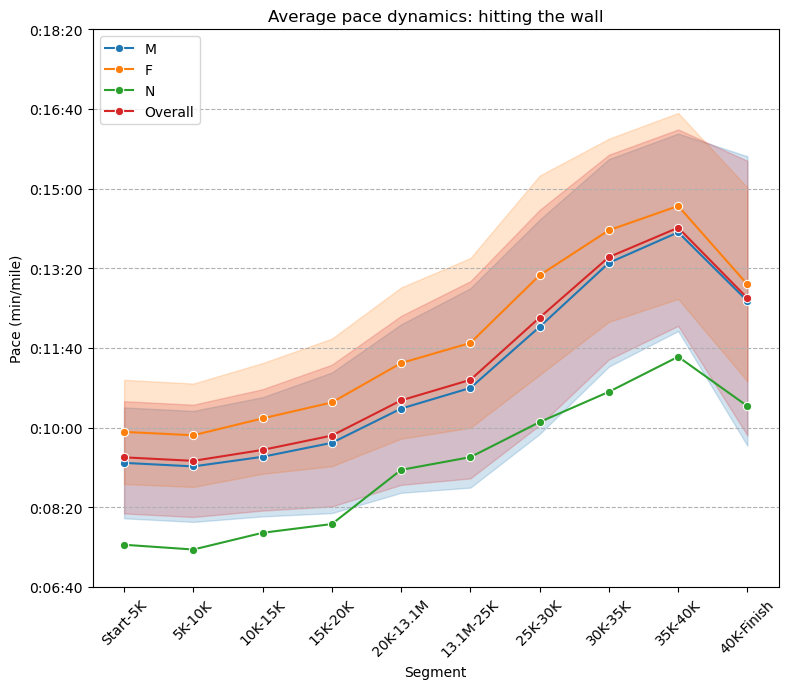

In [25]:
plot_average_pace(df[hit_the_wall], 'hitting the wall')

The average pace dynamics in the 10 most extreme cases looks as follow.

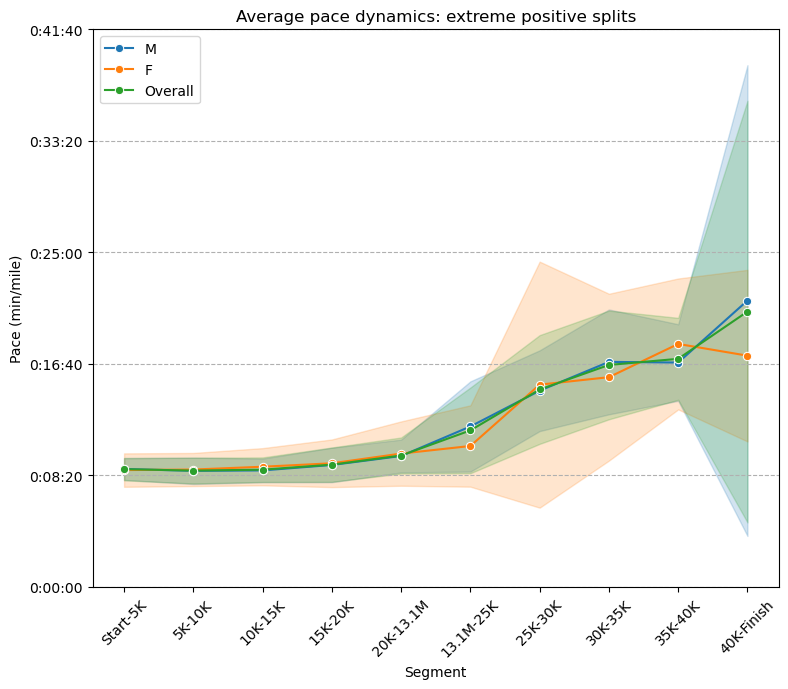

,half,second_half,final,relative_half_diff
3766,1:46:17,3:58:51,5:45:08,124.73%
2004,1:54:26,3:22:21,5:16:47,76.83%
1970,1:32:34,2:41:04,4:13:38,74.00%
5480,1:58:01,3:25:04,5:23:05,73.76%
6104,2:11:38,3:48:38,6:00:16,73.69%
5261,1:44:05,2:58:39,4:42:44,71.64%
4981,2:09:55,3:42:15,5:52:10,71.07%
89,2:00:41,3:26:10,5:26:51,70.83%
6315,1:56:16,3:18:03,5:14:19,70.34%
4232,2:11:10,3:43:14,5:54:24,70.19%


In [26]:
top_positive_splits = df['relative_half_diff'].nlargest(10).index

positive_splits_table = df[['half', 'second_half', 'final', 'relative_half_diff']].loc[top_positive_splits].copy()
columns_to_format = ['half', 'second_half', 'final']
positive_splits_table[columns_to_format] = positive_splits_table[columns_to_format].apply(lambda row: row.map(readable_time))
positive_splits_table[['relative_half_diff']] = positive_splits_table[['relative_half_diff']].map(lambda x: f'{(100 * x):.2f}%')

plot_average_pace(df.loc[top_positive_splits], 'extreme positive splits')
positive_splits_table

### 3. Correlations

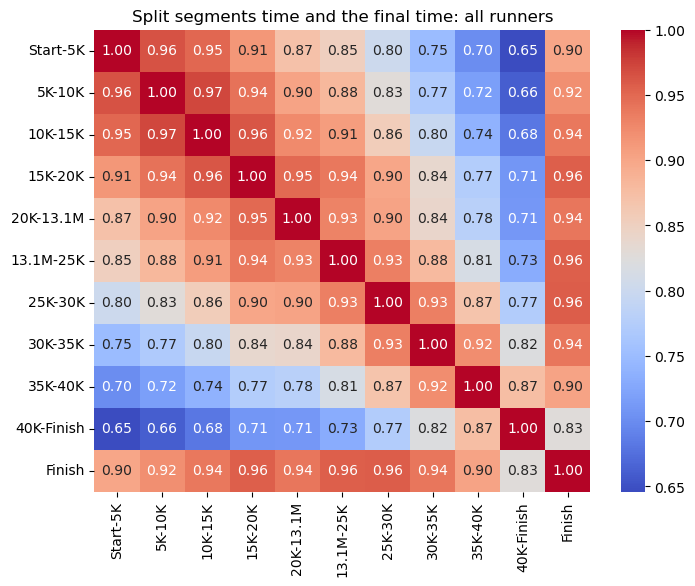

In [27]:
correlation_df = df[segment_time_columns + ['final']]
correlation_matrix = correlation_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, 
            xticklabels = segment_labels + ['Finish'], yticklabels=segment_labels + ['Finish'],
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Split segments time and the final time: all runners')
plt.show()

### 4. Anomalies

We identify the runners who had dropped out of the race.

In [28]:
final_split = segment_time_columns[-1]

dnf = df_missing[final_split].isna()
df_missing.loc[dnf, segment_pace_columns].apply(lambda row: row.map(readable_time))

,split_1_pace,split_2_pace,split_3_pace,split_4_pace,split_5_pace,split_6_pace,split_7_pace,split_8_pace,split_9_pace,split_10_pace
runner_id,,,,,,,,,,
1045,0:13:28,0:13:40,0:15:07,0:14:04,0:14:51,0:13:40,NaN,NaN,NaN,NaN
3283,0:13:12,0:13:34,0:13:49,0:13:52,0:14:32,0:14:31,0:15:11,NaN,NaN,NaN
3785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4801,0:12:58,0:13:11,0:13:46,0:14:14,0:15:24,0:14:46,0:15:33,NaN,NaN,NaN
5490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6236,0:11:08,0:13:17,0:13:31,0:14:23,0:17:30,0:16:13,0:16:37,NaN,NaN,NaN
6412,0:13:25,0:14:48,0:16:25,0:15:26,0:14:41,0:15:30,NaN,NaN,NaN,NaN
6795,0:10:08,0:11:09,0:11:41,0:10:14,0:10:35,0:10:39,0:13:04,0:11:00,NaN,NaN


Let us identify the runners who had missed more than two checkpoints (timing mats), but crossed the finish line. This could have happened due to RFID chip malfunctioning or for other reasons.

In [29]:
multiple_misses = (df_missing[segment_pace_columns].isna().sum(axis=1) > 2) & ~df_missing[final_split].isna()
df_missing.loc[multiple_misses, segment_pace_columns].apply(lambda row: row.map(readable_time))

,split_1_pace,split_2_pace,split_3_pace,split_4_pace,split_5_pace,split_6_pace,split_7_pace,split_8_pace,split_9_pace,split_10_pace
runner_id,,,,,,,,,,
1220,NaN,NaN,NaN,0:10:11,NaN,NaN,0:11:37,0:12:37,0:11:58,0:11:12
4211,0:12:31,0:12:53,0:13:19,NaN,NaN,NaN,NaN,NaN,NaN,0:09:43
7615,0:07:34,0:07:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0:06:59
8973,NaN,NaN,NaN,NaN,NaN,NaN,0:09:08,0:09:40,0:09:36,0:08:59
9790,0:13:13,0:13:43,0:15:10,NaN,NaN,NaN,0:08:57,0:09:14,0:09:40,0:08:54
12288,0:15:20,NaN,NaN,NaN,0:10:41,0:10:55,0:11:13,0:11:45,0:11:40,0:10:21
12824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0:08:02,0:07:34
16628,0:09:12,0:08:48,NaN,NaN,0:09:10,0:08:59,0:09:33,NaN,NaN,0:09:00
18013,0:09:28,0:09:01,NaN,NaN,NaN,NaN,0:09:21,0:09:18,0:09:58,0:08:43


Large values of the standard deviation of the pace, as sampled along the race course, may be considered an anomaly.

In [30]:
df['pace_std'] = df[segment_pace_columns].std(axis=1)
largest_std = df['pace_std'].nlargest(10).index
df.loc[largest_std, segment_pace_columns].apply(lambda row: row.map(readable_time))

,split_1_pace,split_2_pace,split_3_pace,split_4_pace,split_5_pace,split_6_pace,split_7_pace,split_8_pace,split_9_pace,split_10_pace
2004,0:08:46,0:08:44,0:08:47,0:08:37,0:08:57,0:08:45,0:08:57,0:09:56,0:11:28,1:04:34
3766,0:08:07,0:07:50,0:07:59,0:08:18,0:09:21,0:12:18,0:15:30,0:22:45,0:21:04,0:18:23
5261,0:07:51,0:07:54,0:08:00,0:07:59,0:08:16,0:08:23,0:08:37,0:11:16,0:21:37,0:21:49
1234,0:11:05,0:11:13,0:10:45,0:11:00,0:28:33,0:12:36,0:12:14,0:16:20,0:15:16,0:10:55
5148,0:08:39,0:08:46,0:08:32,0:08:16,0:08:44,0:08:21,0:08:34,0:08:53,0:24:29,0:09:55
6242,0:08:41,0:08:19,0:09:00,0:09:39,0:11:04,0:11:01,0:11:12,0:23:41,0:11:48,0:10:00
6208,0:08:06,0:08:11,0:08:17,0:08:06,0:08:26,0:08:04,0:08:27,0:09:59,0:19:58,0:16:59
4232,0:09:37,0:09:39,0:09:58,0:10:30,0:11:40,0:12:41,0:21:37,0:20:05,0:14:42,0:12:45
4627,0:08:55,0:08:47,0:08:53,0:08:50,0:09:13,0:09:02,0:09:15,0:10:20,0:19:20,0:18:55
1542,0:08:37,0:08:25,0:08:32,0:08:17,0:08:28,0:09:12,0:08:49,0:10:52,0:18:59,0:18:28


Similarly, as another metric, let us take a look at the runners with extreme values of the total variation of the pace, that is, the sum of the absolute values of the differences of the paces for all pairs of consecutive split segments.

In [31]:
df['var'] = df[segment_pace_columns].diff(axis=1).abs().sum(axis=1)
largest_var = df['var'].nlargest(10).index
df.loc[largest_var, segment_pace_columns].apply(lambda row: row.map(readable_time))

,split_1_pace,split_2_pace,split_3_pace,split_4_pace,split_5_pace,split_6_pace,split_7_pace,split_8_pace,split_9_pace,split_10_pace
2004,0:08:46,0:08:44,0:08:47,0:08:37,0:08:57,0:08:45,0:08:57,0:09:56,0:11:28,1:04:34
1234,0:11:05,0:11:13,0:10:45,0:11:00,0:28:33,0:12:36,0:12:14,0:16:20,0:15:16,0:10:55
3932,0:09:10,0:16:42,0:09:47,0:11:42,0:15:06,0:12:46,0:15:25,0:16:32,0:16:11,0:09:15
5148,0:08:39,0:08:46,0:08:32,0:08:16,0:08:44,0:08:21,0:08:34,0:08:53,0:24:29,0:09:55
6242,0:08:41,0:08:19,0:09:00,0:09:39,0:11:04,0:11:01,0:11:12,0:23:41,0:11:48,0:10:00
2969,0:17:53,0:09:39,0:10:35,0:12:48,0:11:01,0:11:13,0:18:11,0:15:26,0:16:43,0:13:48
5152,0:08:43,0:08:25,0:08:32,0:09:14,0:15:06,0:09:53,0:11:21,0:16:18,0:11:03,0:11:37
448,0:08:07,0:08:18,0:08:34,0:09:12,0:13:02,0:11:35,0:18:27,0:10:16,0:11:47,0:10:25
4649,0:07:48,0:08:18,0:08:38,0:12:40,0:09:18,0:14:33,0:11:49,0:14:42,0:15:10,0:10:32
3848,0:10:08,0:10:26,0:10:54,0:11:41,0:11:04,0:13:22,0:20:31,0:15:20,0:17:42,0:12:43


It is plausible that in some of these cases, a runner had to take a break on the course, but was able to recuperate for the final stages of the race.